Implement Rosin's Maximum Deviation threshold to binarize a numpy array of values

Created by Anders R. Nelson on 2/10/2020 - Saucerman Lab - University of Virginia

Source : https://www.sciencedirect.com/science/article/pii/S0031320300001369?via%3Dihub


Step1: Import Packages and Get Data 

In [2]:
#import packages we will use
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from statsmodels.nonparametric.kde import KDEUnivariate

Here, we will generate a toy data set <br>
We will have a 1 control group and 2 drug treatment groups <br>
We expect Drug 1 to elicit a response similar to the control,<br>
And Drug 2 will elicit a stronger response<br><br>
We expect ~10% of our negative control values to be above threshold

In [248]:
# make toy data

#draw random samples from gaussian distirbution
np.random.seed(seed=2) #initialize random seed
values=np.zeros(3000) #Establish array of values


for i in range(0,len(values)):
    #loc = mean, scale = standard deviation
    values[i]=np.random.normal(loc=1, scale=.2, size=None) #assign random values from gaussian distribution
print(values) #display values, should get the same numbers each time because we set the seed 

# scale values[1000:2000] and values[2000:3000] as these will be our drug treatment groups
values[950:1000]=values[950:1000]*3 #create some control value that should mark as above threshold
values[900:950]=values[900:950]*2
values[1000:2000]=values[1000:2000]*1.5
values[2000:3000]=values[2000:3000]*2.5
# add some randomness to sampled values
np.random.seed(seed=1)
random=np.zeros(3000)
for i in range(0,len(values)):
    random[i]=np.random.normal(loc=.1, scale=0.05, size=None)
values=values+random
print(values) #display values, should get the same numbers each time because we set the seed 



[0.91664843 0.98874663 0.57276078 ... 0.60139305 0.68953051 0.97637899]
[1.0978657  1.05815881 0.64635219 ... 1.59594965 1.75382512 2.47589418]


In [249]:
#generate dataframe
treatments=list() #generate list of treatment labels
treatments[0:1000]=['control']*1000
treatments[1000:2000]=['drug1']*1000
treatments[2000:3000]=['drug2']*1000
#make dataframe
df=pd.DataFrame({'value':values,'drug':treatments})
print(df) #observe our new dataframe

         value     drug
0     1.097866  control
1     1.058159  control
2     0.646352  control
3     1.374406  control
4     0.784583  control
5     0.816574  control
6     1.287817  control
7     0.812882  control
8     0.904362  control
9     0.905730  control
10    1.283396  control
11    1.455435  control
12    1.092187  control
13    0.857212  control
14    1.264500  control
15    0.925773  control
16    1.087552  control
17    1.291107  control
18    0.952536  control
19    1.130946  control
20    0.869347  control
21    1.125949  control
22    1.196394  control
23    0.927369  control
24    1.077278  control
25    1.018577  control
26    0.966324  control
27    0.815689  control
28    0.802362  control
29    1.095819  control
...        ...      ...
2970  3.539583    drug2
2971  2.335178    drug2
2972  2.601344    drug2
2973  2.320962    drug2
2974  3.198394    drug2
2975  3.214881    drug2
2976  1.700221    drug2
2977  2.127049    drug2
2978  2.988744    drug2
2979  1.873969  

Text(0.5, 1.0, 'Drug2')

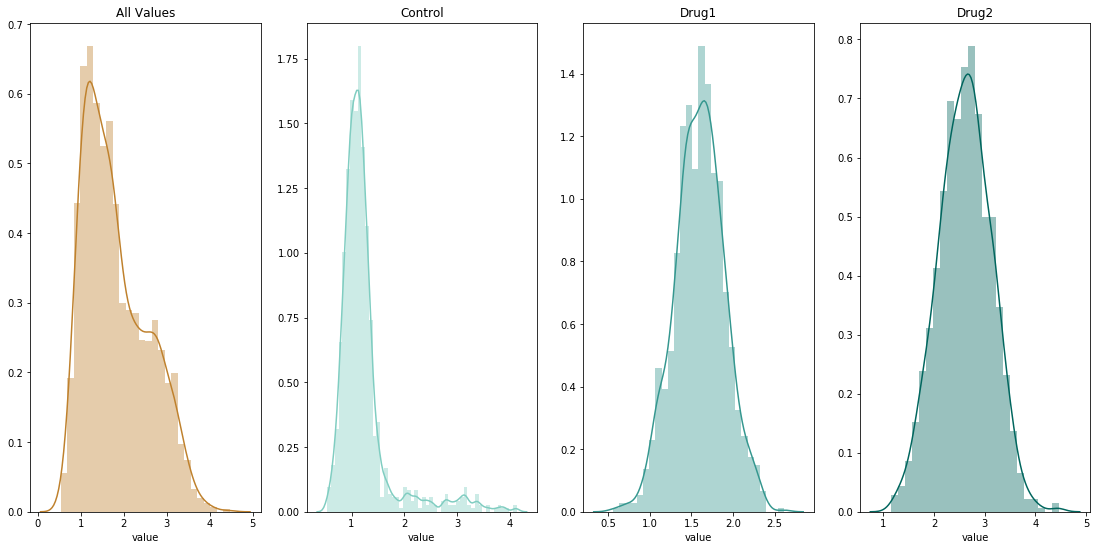

In [250]:
#look at histograms of data

fig, ax=plt.subplots(1,4) #initialize subplots 1-by-4
fig.set_size_inches(19,9)
sns.distplot(df['value'], kde=True, color='#bf812d',ax=ax[0])
ax[0].set_title('All Values')
sns.distplot(df[df['drug']=='control']['value'], kde=True, color='#80cdc1',ax=ax[1]) #kde=True smooths a kernel over the histoigram
ax[1].set_title('Control')
sns.distplot(df[df['drug']=='drug1']['value'], kde=True, color='#35978f',ax=ax[2])
ax[2].set_title('Drug1')
sns.distplot(df[df['drug']=='drug2']['value'], kde=True, color='#01665e',ax=ax[3])
ax[3].set_title('Drug2')

Based on the figure above, we see that our histogram for all values has a left peak, and smaller right peak <br>
The right peak is likely due to the drug2 values.... <br>
Next, let's use teh maximum deviation method to binarize our values into two groups 'high' or 'positive and <br>
'low' or 'negative'<br>
Notice the right tail outliers of the negative control

Step 2: Isolate negative control values and declare the kernel estimation function and parameters

In [251]:
#delcare kernel estimation function
def kde_statsmodels_u(x, x_grid, bandwidth, **kwargs):
    """Univariate Kernel Density Estimation with Statsmodels"""
    kde = KDEUnivariate(x)
    kde.fit(bw=bandwidth, **kwargs)
    return kde.evaluate(x_grid)

In [252]:
#declare kernel estimation parameters
bandwidth = 0.06


Step 3: Determine threshold on negative controls using Rosin's Max Deviation method

In [253]:
#get negative controls
temp=df[df['drug']=='control'] #isolate control group rows from dataframe
vals=temp['value'] #isolate specific metric

Text(0.5, 1.0, 'Raw Histogram')

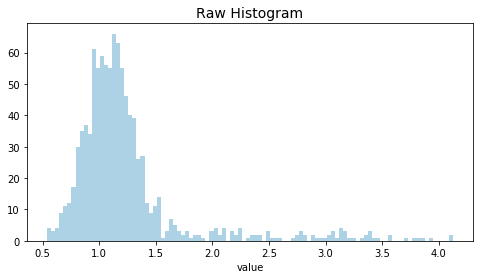

In [254]:
#plot histogram of raw data
fig, ax=plt.subplots(1,1) #initialize subplots 1-by-4
fig.set_size_inches(8,4) # width x height
sns.distplot(temp['value'], kde=False, color='#3690c0', bins=100)
plt.title("Raw Histogram",fontsize=14)

In [255]:
#estimate kernel
x_grid=np.linspace(0,np.max(vals),100) #x-coordinates for data points in the kernel 
kernel=kde_statsmodels_u(vals,x_grid,bandwidth) #get kernel


Text(0.5, 1.0, 'Kernal Density Estimation')

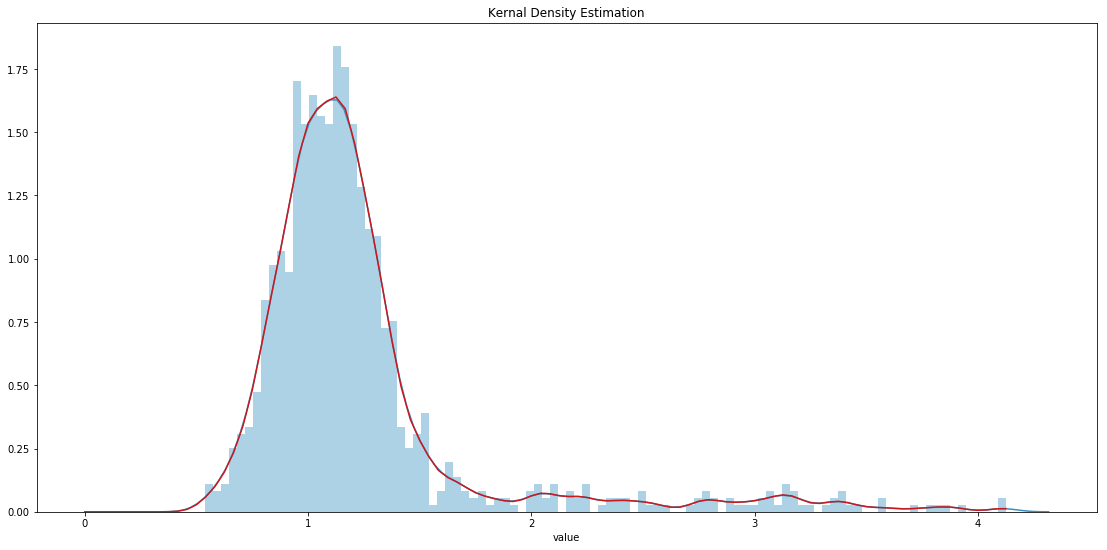

In [256]:
#plot kernel over histogram
# this time we set KDE to 'True' to normalize the histogram values
fig, ax=plt.subplots()
fig.set_size_inches(19, 9)
sns.distplot(temp['value'], kde=True, color='#3690c0', bins=100) 
plt.plot(x_grid,kernel,'#cb181d')
plt.title('Kernal Density Estimation')

Note: in the above figure, the red line is our calulated kernel. The blue line is produced by the plotting function and should be ignored.<br>

<b> IMPORTANT: The red kernel line should look less smooth than the blue kernel line. If the line too smooth then adust<br> 
    the bandwith parameter above. <b>
   

In [257]:
#get the index of the kernal peak
maxIndex=np.argmax(kernel)

In [258]:
#Assign percent below the max kernel value for the 'zero' peak i.e. a value of = 2% the maximum value

maxPercent=1

In [259]:
#assign x and y coords for peak-to-base line
x1=x_grid[maxIndex]
y1=kernel[maxIndex]
#find all local minima in the kernel
local_mins=np.where(np.r_[True, kernel[1:] < kernel[:-1]] & np.r_[kernel[:-1] < kernel[1:], True])
local_mins=local_mins[0] #un 'tuple' local mins
#filter for points below a certain kernel max
local_mins=local_mins[(np.where(kernel[local_mins]<(y1/(100/maxPercent))))]
#get local minima beyond the peak
local_mins=local_mins[(np.where(local_mins > maxIndex))] # get local minima that meet percent max threshold
x2_index=local_mins[0] # find minumum beyond peak of kernel
x2=x_grid[x2_index] #index to local min beyond kernel peak
y2=kernel[x2_index]




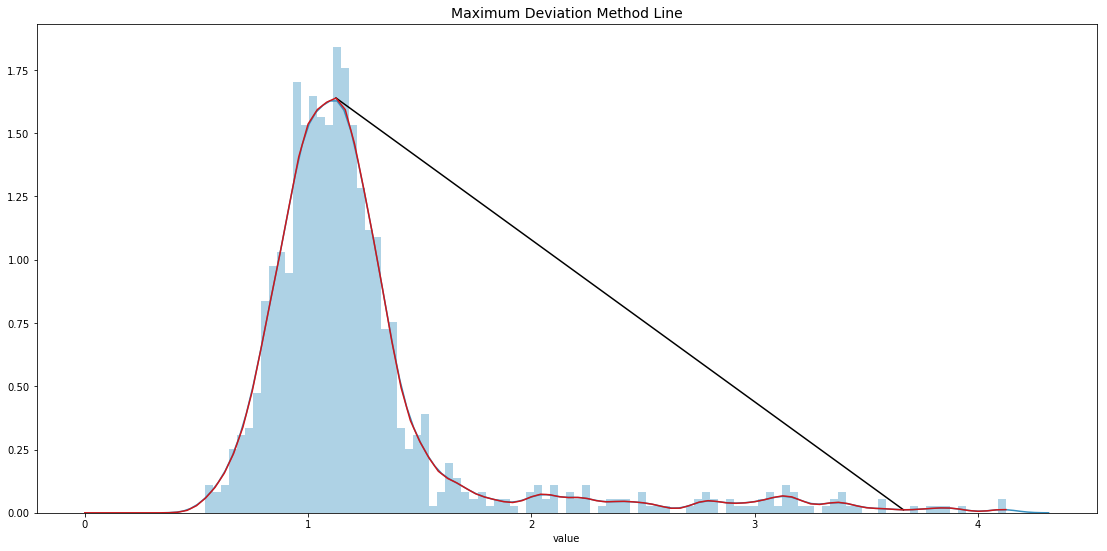

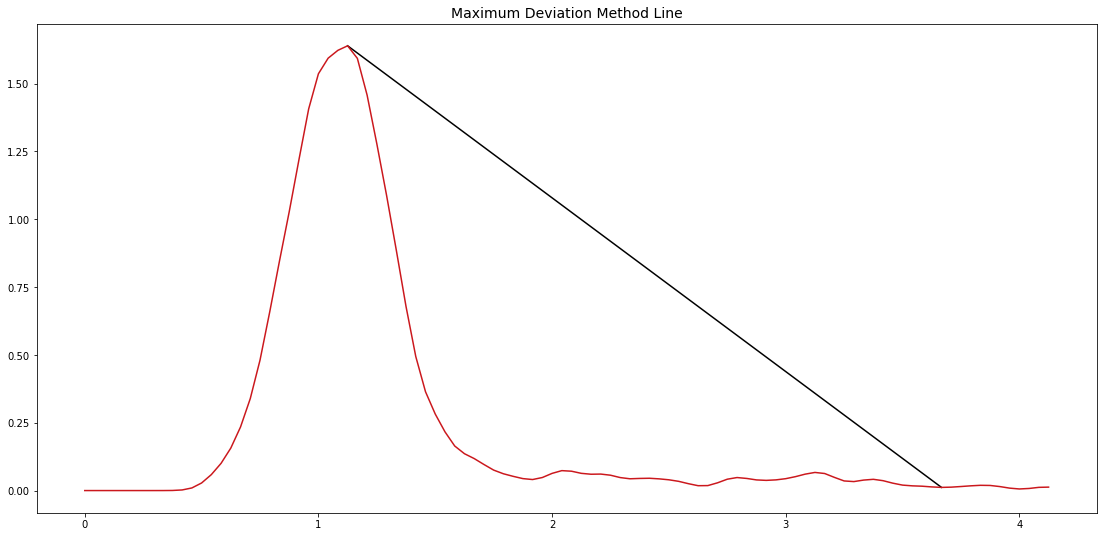

In [260]:
#plot points and line over histogram
fig, ax=plt.subplots()
fig.set_size_inches(19, 9)
sns.distplot(temp['value'], kde=True, color='#3690c0', bins=100)
plt.plot([x1,x2],[y1,y2],'k-')
plt.title("Maximum Deviation Method Line",fontsize=14)
plt.plot(x_grid,kernel,'#cb181d')
#plot without histogram
fig, ax=plt.subplots()
fig.set_size_inches(19, 9)
plt.plot([x1,x2],[y1,y2],'k-')
plt.title("Maximum Deviation Method Line",fontsize=14)
plt.plot(x_grid,kernel,'#cb181d')

In [261]:
#calculate line slope and get tangent line
slope=(y2-y1)/(x2-x1) 
#find y_intercept for line
y_int=y1-(slope*x1)
slopeTan=-1/slope #tangent line slope

In [262]:
#allocate lists for x-y coordinates and distance values
dist=list()
#save x-y coords of intersect points
yii=list()
xii=list()

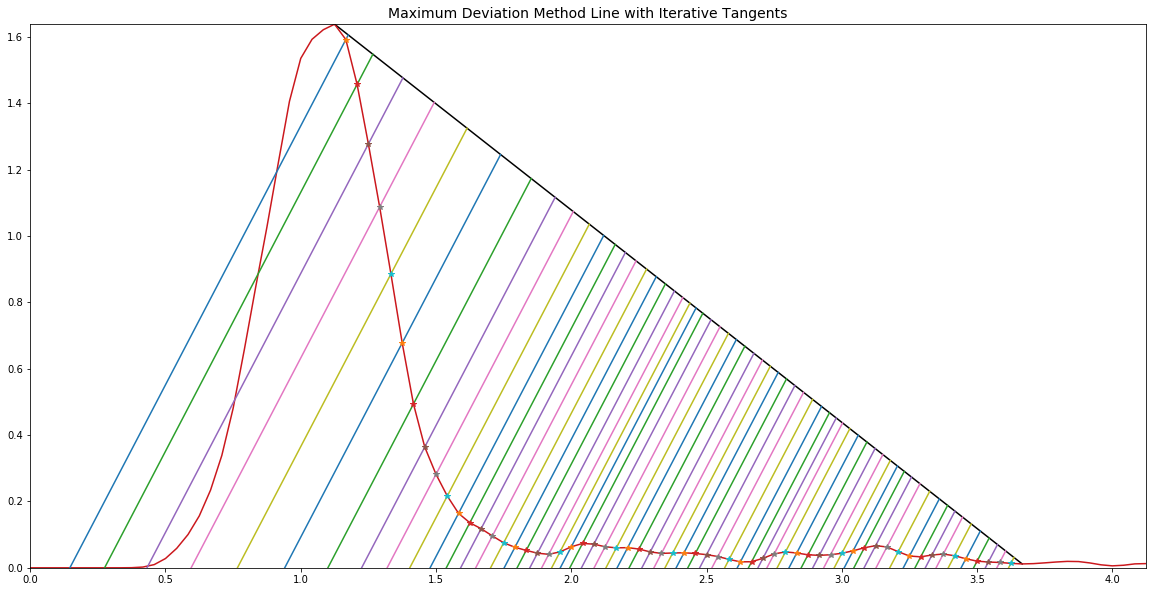

In [263]:
#starting at the first point past the kernel peak (maxIndex+1), 
#calculate distance between kernel point and tangent intersection on the Rosin line
#plot each generated tangent line, establish plot
fig, ax=plt.subplots()
fig.set_size_inches(20, 10)
plt.plot([x1,x2],[y1,y2],'k-')
plt.title("Maximum Deviation Method Line with Iterative Tangents",fontsize=14)
plt.plot(x_grid,kernel,'#cb181d')
plt.xlim(0,np.max(x_grid))
plt.ylim(0,np.max(kernel))
#iterate and generate tangent lines
for i in range(maxIndex+1,x2_index):
#find intersection point between lines
    #determine equation of the tangent line based on current bin coordinate
    xt1=x_grid[i]
    yt1=kernel[i]
    y_int_tan=yt1-(slopeTan*xt1)
    #calculate intersection point between lines
    b1=y_int
    b2=y_int_tan
    m1=slope
    m2=slopeTan
    # y = mx + b
    # Set both lines equal to find the intersection point in the x direction, y1=y2, x1=x2
    # y1 = m1 * x + b1, y2 = m2 * x + b2
    #if y1 == y2...
    # m1 * x + b1 = m2 * x + b2
    # m1 * x - m2 * x = b2 - b1
    # x * (m1 - m2) = b2 - b1
    # x = (b2 - b1) / (m1 - m2)
    xi = (b2 - b1) / (m1 - m2)
    # Now solve for y -- use either line, because they are equal here
    # y = mx + b
    yi = m1 * xi + b1
    #plot line
    plt.plot([xi,0],[yi,y_int_tan])
    #assert that the new line generated is equal or very close to the correct tangent value of the max deviation line
    assert((m2-m2*.01)<((yi-y_int_tan)/(xi-0))<(m2+m2*.01)) # an error will throw if this statement is false
    plt.plot(xt1,yt1,'*')
    #save x-y coordinates of the point
    yii.append(yi)
    xii.append(xi)
    #get euclidean distance between kernel coordinate and intersect point
    euc=math.sqrt((xi-xt1)**2+(yi-yt1)**2)
    #store the euclidean distance
    dist.append(euc)

<b> Observe the iterative tangent lines in the plot above, and the distances from the kernel 
    to the max deviation line <b>

In [264]:
#get kernel point with the maximum distance from the Rosin line
#remeber, we started at maxIndex+1, so the index of the optimalPoint in the kernel array will be maxIndex+1 
#+ the index in the 'dist' array
optimalPoint=np.argmax(dist)+maxIndex+1 

Max deviation line slope: -0.6403328561520425
Calculated slope between plotted points: 1.5616877853329412
Inverse of calculated slope between plotted points... 
(Should be very close to max deviation slope): -0.6403328561520425


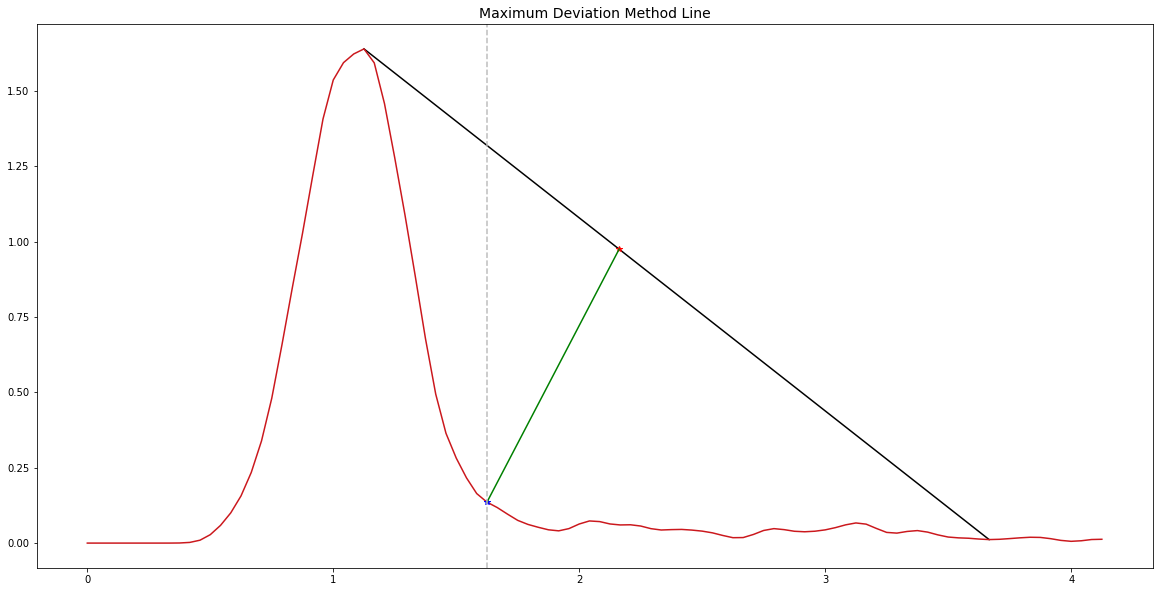

In [265]:
#plot the optimal point over the kernel with Rosin line we plotted before
fig, ax=plt.subplots()
fig.set_size_inches(20, 10)
plt.plot([x1,x2],[y1,y2],'k-')
plt.title("Maximum Deviation Method Line",fontsize=14)
plt.plot(x_grid,kernel,'#cb181d')
#add optimalPoint and line intersection
plt.plot(x_grid[optimalPoint],kernel[optimalPoint],'b*') #point on max deviation line
plt.plot(xii[np.argmax(dist)],yii[np.argmax(dist)],'r*') #point on kernel
plt.plot([x_grid[optimalPoint],xii[np.argmax(dist)]],[kernel[optimalPoint],yii[np.argmax(dist)]],'g-')
threshold=x_grid[optimalPoint]
plt.axvline(x=threshold,linestyle='--',color='#bdbdbd')
print('Max deviation line slope: '+str(slope))
print('Calculated slope between plotted points: '+str((kernel[optimalPoint]-yii[np.argmax(dist)])/(x_grid[optimalPoint]-xii[np.argmax(dist)])))
print('Inverse of calculated slope between plotted points... \n(Should be very close to max deviation slope): '+str(-1/((kernel[optimalPoint]-yii[np.argmax(dist)])/(x_grid[optimalPoint]-xii[np.argmax(dist)]))))

Interpret the figure above as follows:<br>
Red and Blue points: Points for max deviation tangent line<br>
Green line: Tangent line between points<br>
Gray dashed line: New threshold for binarization

<b>Now, let's apply this threshold to all of our treatment groups...<b>

Text(0.5, 1.0, 'Drug #2: 97.1% above threshold')

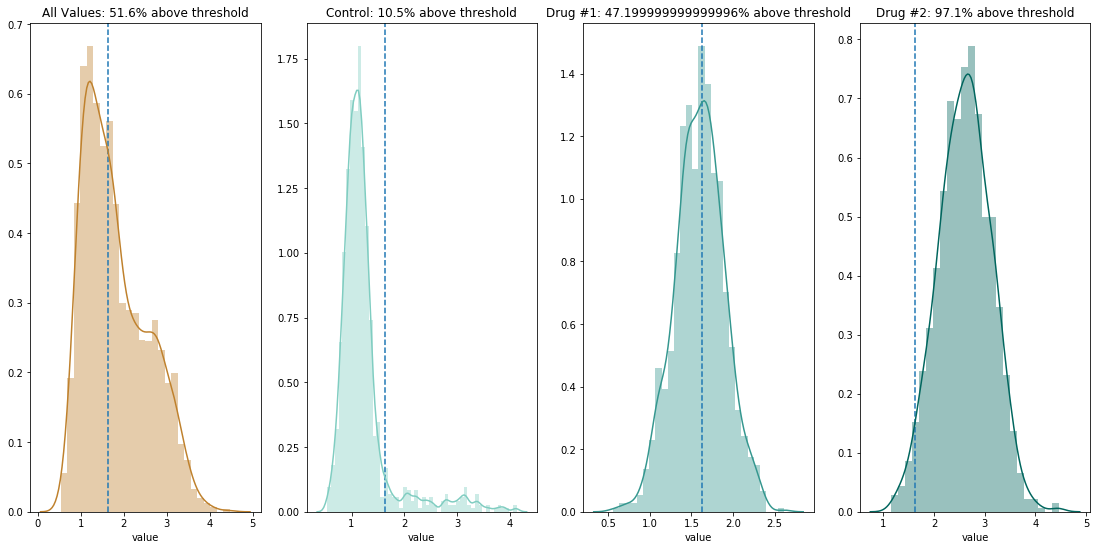

In [267]:
# calculate % above threshold for each group


fig, ax=plt.subplots(1,4) #initialize subplots 1-by-4
fig.set_size_inches(19,9)
#all values
percent=(len(df[df['value']>=threshold])/len(df))*100
ax[0].axvline(x=threshold, linestyle='--')
sns.distplot(df['value'], kde=True, color='#bf812d',ax=ax[0])
ax[0].set_title('All Values: '+str(percent)+'% above threshold')
#negative controls
temp=df[df['drug']=='control']
percent=len(temp[temp['value']>=threshold])/len(temp)*100
ax[1].axvline(x=threshold, linestyle='--')
sns.distplot(temp['value'], kde=True, color='#80cdc1',ax=ax[1]) #kde=True smooths a kernel over the histoigram
ax[1].set_title('Control: '+str(percent)+'% above threshold')
#drug 1 group
temp=df[df['drug']=='drug1']
percent=len(temp[temp['value']>=threshold])/len(temp)*100
ax[2].axvline(x=threshold, linestyle='--')
sns.distplot(temp['value'], kde=True, color='#35978f',ax=ax[2]) #kde=True smooths a kernel over the histoigram
ax[2].set_title('Drug #1: '+str(percent)+'% above threshold')
#drug 2 group
temp=df[df['drug']=='drug2']
percent=len(temp[temp['value']>=threshold])/len(temp)*100
ax[3].axvline(x=threshold, linestyle='--')
sns.distplot(temp['value'], kde=True, color='#01665e',ax=ax[3]) #kde=True smooths a kernel over the histoigram
ax[3].set_title('Drug #2: '+str(percent)+'% above threshold')



<b>As expected, out negative controls are ~10% positive. Drug1 has a moderate effect while drug 2<br>
   has a stronger effect. That's the end of the notebook!<b>

For questions, please contact Anders Nelson: arn4va@virginia.edu, github:andersnelson